In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from utils_probability_distributions import *

In [3]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"],
    "axes.labelsize": 12,
    "font.size": 12,
    "legend.fontsize": 11,
    "xtick.labelsize": 11,
    "ytick.labelsize": 11,
})

# Classical Risk Estimation

Let $X$ be a real-valued random variable representing losses, and let $\alpha \in (0,1)$ be a tail probability level.<br>
If $X < 0$, this corresponds to a gain (profit).<br>
If $X > 0$, this corresponds to a loss.

In [4]:
n_samples = 1000

def ecdf(samples: np.ndarray):
    """Return x (sorted) and empirical CDF values."""
    x = np.sort(np.asarray(samples).ravel())
    n = x.size
    y = np.arange(1, n + 1) / n
    return x, y

def plot_cdf_comparison(
    sampled,
    perfect_cdf=None,          # callable: F(x) -> CDF
    perfect_x=None,            # optional grid for "perfect" curve
    perfect_cdf_values=None,   # optional precomputed CDF on perfect_x
    xlim=None,
    title="CDF: sampled vs perfect",
    label_sampled="Sampled (empirical CDF)",
    label_perfect="Perfect (analytical CDF)",
):
    # Empirical CDF from samples
    xs, ys = ecdf(sampled)

    # Build x-grid for perfect CDF if not supplied
    if perfect_x is None:
        lo = np.min(xs) if xlim is None else xlim[0]
        hi = np.max(xs) if xlim is None else xlim[1]
        perfect_x = np.linspace(lo, hi, 2000)

    # Perfect CDF values (either callable or precomputed)
    if perfect_cdf_values is None:
        if perfect_cdf is None:
            raise ValueError("Provide either perfect_cdf (callable) or (perfect_x, perfect_cdf_values).")
        perfect_cdf_values = perfect_cdf(perfect_x)

    # Plot
    plt.figure(figsize=(7, 4.5))
    plt.step(xs, ys, where="post", linewidth=2, label=label_sampled)
    plt.plot(perfect_x, perfect_cdf_values, linewidth=2, label=label_perfect)

    if xlim is not None:
        plt.xlim(*xlim)

    plt.ylim(0, 1)
    plt.xlabel("x")
    plt.ylabel("CDF")
    plt.title(title)
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

## Loss Models Considered

To see how different risk measures behave under different distribution, we study
three classical distributions for the loss variable $X$.


### Normal distribution: $X \sim \mathcal{N}(\mu,\sigma^2)$<br>


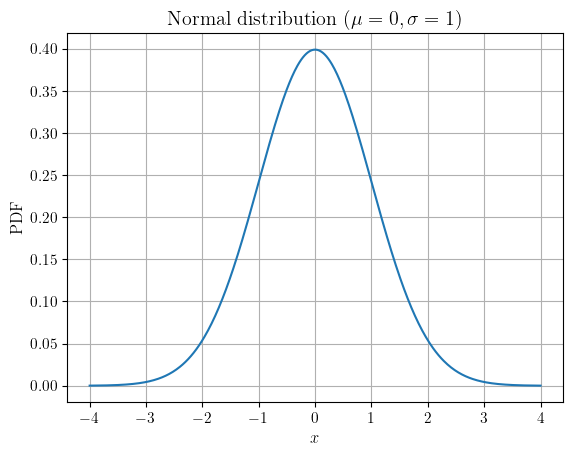

In [5]:
from scipy.stats import norm

normal_mu = 0.0
normal_sigma = 1.0

x = np.linspace(normal_mu - 4*normal_sigma, normal_mu + 4*normal_sigma, 500)
y = norm.pdf(x)

plt.figure()
plt.plot(x, y)
plt.xlabel(r"$x$")
plt.ylabel(r"PDF")
plt.title(r"Normal distribution ($\mu=0, \sigma=1$)")
plt.grid(True)
plt.show()

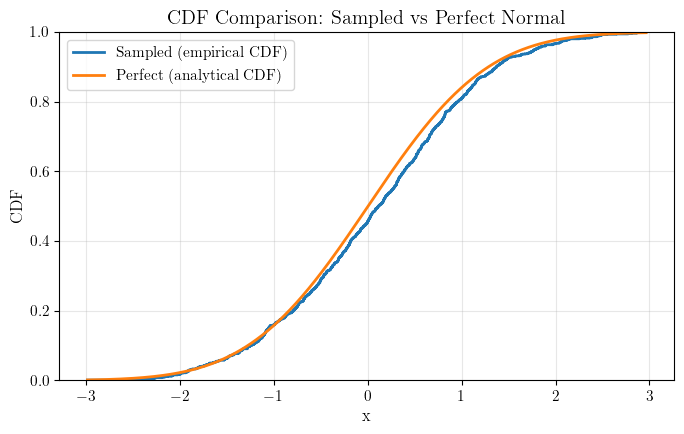

In [6]:
normal_samples = np.random.normal(loc=normal_mu, scale=normal_sigma, size=n_samples)

plot_cdf_comparison(
    sampled=normal_samples,
    perfect_cdf=lambda x: norm.cdf(x, loc=normal_mu, scale=normal_sigma),
    title="CDF Comparison: Sampled vs Perfect Normal"
)

### Lognormal distribution: $\log X \sim \mathcal{N}(\mu,\sigma^2)$ <br>

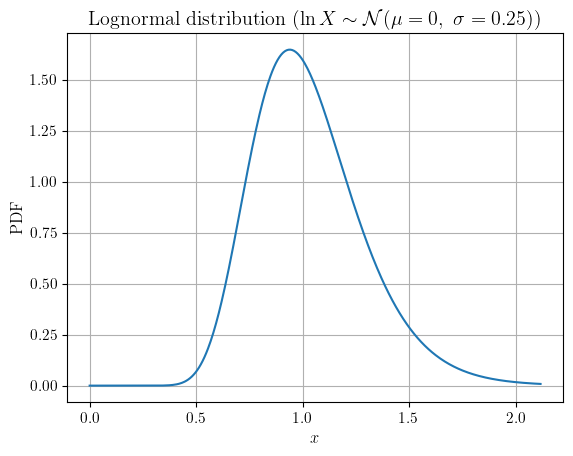

In [7]:
from scipy.stats import lognorm

lognorm_mu = 0
lognorm_sigma = 0.25

x = np.linspace(1e-4, np.exp(lognorm_mu + 3*lognorm_sigma), 500)
y = lognorm.pdf(x, s=lognorm_sigma, scale=np.exp(lognorm_mu))

plt.figure()
plt.plot(x, y)
plt.xlabel(r"$x$")
plt.ylabel("PDF")
plt.title(r"Lognormal distribution ($\ln X \sim \mathcal{N}(\mu=0,\ \sigma=0.25)$)")
plt.grid(True)
plt.show()


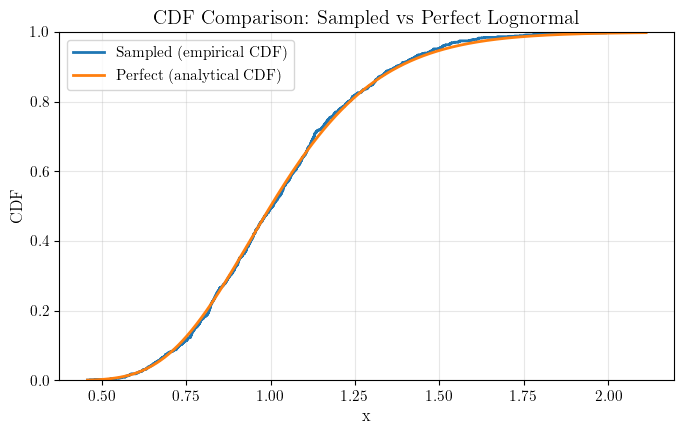

In [8]:
lognormal_samples = np.random.lognormal(mean=lognorm_mu, sigma=lognorm_sigma, size=n_samples)

plot_cdf_comparison(
    sampled=lognormal_samples,
    perfect_cdf=lambda x: lognorm.cdf(
        x,
        s=lognorm_sigma,        # shape parameter
        scale=np.exp(lognorm_mu)
    ),
    title="CDF Comparison: Sampled vs Perfect Lognormal"
)

### Student-t distribution: $X \sim t_\nu(\mu,\sigma)$<br>

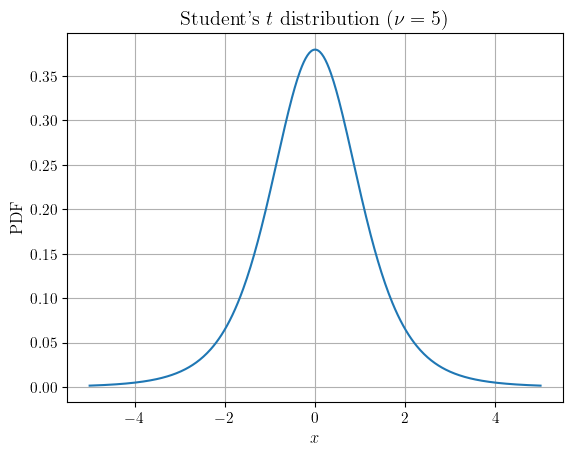

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import t

student_df = 5
student_loc = 0.0
student_scale = 1.0

x = np.linspace(-5, 5, 500)
y = t.pdf(x, df=student_df, loc=student_loc, scale=student_scale)

plt.figure()
plt.plot(x, y)
plt.xlabel(r"$x$")
plt.ylabel(r"PDF")
plt.title(r"Student's $t$ distribution ($\nu=5$)")
plt.grid(True)
plt.show()


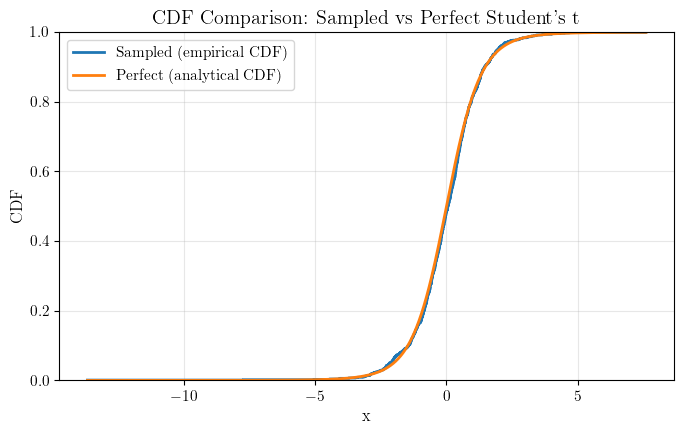

In [10]:
student_samples = student_loc + student_scale * np.random.standard_t(df=student_df, size=n_samples)

plot_cdf_comparison(
    sampled=student_samples,
    perfect_cdf=lambda x: t.cdf(
        (x - student_loc) / student_scale,  # standardize
        df=student_df
    ),
    title="CDF Comparison: Sampled vs Perfect Student's t"
)

## Value at Risk (VaR)

\begin{equation}
\mathrm{VaR}_\alpha(X)
=
\inf \left\{ x \in \mathbb{R} \;\middle|\; \mathbb{P}(X \le x) \ge \alpha \right\}
\end{equation}

In [11]:
alpha = 0.95

In [12]:
# Analytical calculation of the VaR for a normal distribution
normal_var = normal_mu + normal_sigma * norm.ppf(alpha)
print(normal_var)

# Numerical estimation of the VaR using Monte Carlo simulation
normal_mc_var = np.percentile(normal_samples, alpha * 100)
print(normal_mc_var)

1.644853626951472
1.7753824730988585


In [13]:
# Analytical calculation of the VaR for a lognormal distribution
lognormal_var = np.exp(lognorm_mu + lognorm_sigma * norm.ppf(alpha))
print(lognormal_var)

# Numerical estimation of the VaR using Monte Carlo simulation
lognormal_mc_var = np.percentile(lognormal_samples, alpha * 100)
print(lognormal_mc_var)


1.5086472777008935
1.482111321739384


In [14]:
# Analytical calculation of the VaR for a Student's t distribution
student_var = student_loc + student_scale * t.ppf(alpha, df=student_df)
print(student_var)


# Numerical estimation of the VaR using Monte Carlo simulation
student_mc_var = np.percentile(student_samples, alpha * 100)
print(student_mc_var)

2.015048373333023
1.9479465318127533


## Conditional Value at Risk (CVaR)

\begin{equation}
\mathrm{CVaR}_{\alpha}(X)
=
\frac{1}{1 - \alpha}
\int_\alpha^1 \mathrm{VaR}_u(X)\,du
\end{equation}

In [15]:
alpha = 0.95

In [16]:
# Analytical calculation of the CVaR for a normal distribution
normal_cvar = normal_mu + normal_sigma * norm.pdf(norm.ppf(alpha)) / (1 - alpha)
print(normal_cvar)

# Numerical estimation of the CVaR using Monte Carlo simulation
normal_mc_cvar = normal_samples[normal_samples >= normal_mc_var].mean()
print(normal_mc_cvar)

2.0627128075074275
2.1842222683066437


In [17]:
# Analytical calculation of the CVaR for a lognormal distribution
lognormal_cvar = (
    np.exp(lognorm_mu + 0.5 * lognorm_sigma**2)
    * norm.cdf(lognorm_sigma - norm.ppf(alpha))
    / (1 - alpha)
)
print(lognormal_cvar)

# Numerical estimation of the CVaR using Monte Carlo simulation
lognormal_mc_cvar = lognormal_samples[lognormal_samples >= lognormal_mc_var].mean()
print(lognormal_mc_cvar)


1.6823606305486865
1.625715066248269


In [18]:
# Analytical CVaR (only valid if student_df > 1)
z = (student_var - student_loc) / student_scale  # standardized VaR

student_cvar = (
    student_loc
    + student_scale
    * ((student_df + z**2) / (student_df - 1))
    * (t.pdf(z, df=student_df) / (1 - alpha))
)
print(student_cvar)

# Monte Carlo CVaR
student_mc_cvar = student_samples[student_samples >= student_mc_var].mean()
print(student_mc_cvar)

2.8901289462730744
2.8129966463769747


## Range Value at Risk (RVaR)

\begin{equation}
\mathrm{RVaR}_{\alpha_1,\alpha_2}(X)
=
\frac{1}{\alpha_2 - \alpha_1}
\int_{\alpha_1}^{\alpha_2} \mathrm{VaR}_u(X)\,du
\end{equation}

In [19]:
alpha1 = 0.80
alpha2 = 0.90

In [20]:
# Analytical calculation of the RVaR for a normal distribution
normal_rvar = normal_mu + normal_sigma * (norm.pdf(norm.ppf(alpha1)) - norm.pdf(norm.ppf(alpha2))) / (alpha2 - alpha1)
print(normal_rvar)

# Numerical estimation of the RVaR using Monte Carlo simulation
sorted_samples = np.sort(normal_samples)
n = len(sorted_samples)
i1 = max(int(np.ceil(alpha1 * n)),0)
i2 = min(int(np.floor(alpha2 * n)),n)
normal_mc_rvar = sorted_samples[i1:i2].mean()
print(normal_mc_rvar)


1.044635884753215
1.1452385315804072


In [21]:
# Analytical calculation of the RVaR for a normal distribution (range [alpha1, alpha2])
lognormal_rvar = (
    np.exp(lognorm_mu + 0.5 * lognorm_sigma**2)
    * (norm.cdf(norm.ppf(alpha2) - lognorm_sigma) - norm.cdf(norm.ppf(alpha1) - lognorm_sigma))
    / (alpha2 - alpha1)
)
print(lognormal_rvar)

# Numerical estimation of the RVaR using Monte Carlo simulation
sorted_samples = np.sort(lognormal_samples)
n = len(sorted_samples)
i1 = max(int(np.ceil(alpha1 * n)),0)
i2 = min(int(np.floor(alpha2 * n)),n)
lognorm_mc_rvar = sorted_samples[i1:i2].mean()
print(lognorm_mc_rvar)

1.2990785031680094
1.2966291343965892


In [22]:
from scipy.integrate import quad

# Analytical calculation of the RVaR for a Student's t distribution (range [alpha1, alpha2])
# There is no simple closed-form expression for the RVaR of a Student's t distribution.

def student_var_u(u):
    return student_loc + student_scale * t.ppf(u, df=student_df)

student_rvar = quad(student_var_u, alpha1, alpha2, limit=20)[0] / (alpha2 - alpha1)
print(student_rvar)


# Numerical estimation of the RVaR using Monte Carlo simulation
sorted_samples = np.sort(student_samples)
n = len(sorted_samples)
i1 = max(int(np.ceil(alpha1 * n)),0)
i2 = min(int(np.floor(alpha2 * n)),n)
student_mc_rvar = sorted_samples[i1:i2].mean()
print(student_mc_rvar)

1.1693848193242924
1.189490565947236


## Complete Runs

In [ ]:
from plot_utils import plot_monte_carlo_results

In [23]:
! python run_monte_carlo.py --dist normal  --mu 0 --sigma 1 --n-samples 16 32 64 128 256 512 1024 2048 4096 8192 --rep 100 --alpha 0.95 --alpha1 0.8 --alpha2 0.9 --seed 0 --reps-out normal_output.csv

In [26]:
plot_monte_carlo_results('normal_output.csv', analytical_values={
    'VaR': normal_var,
    'CVaR': normal_cvar,
    'RVaR': normal_rvar
})

NameError: name 'plot_monte_carlo_results' is not defined

In [24]:
! python run_monte_carlo.py --dist lognorm --mu 0 --sigma 1 --n-samples 16 32 64 128 256 512 1024 2048 4096 8192 --rep 100 --alpha 0.95 --alpha1 0.8 --alpha2 0.9 --seed 0 --reps-out lognormal_output.csv

In [25]:
! python run_monte_carlo.py --dist student --df 5 --loc 0 --scale 1 --n-samples 16 32 64 128 256 512 1024 2048 4096 8192 --rep 100 --alpha 0.95 --alpha1 0.8 --alpha2 0.9 --seed 0 --reps-out student_output.csv
